In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import re
from PIL import Image
from dispnet_c import DispNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
###########################读取driving数据
path = "F:/dataset/driving/frames_cleanpass/15mm_focallength/scene_forwards/slow"
pathd = "F:/dataset/driving/disparity_img/15mm_focallength/scene_forwards/slow"

def trainGenerator(batch_size):

    aug_dict = dict(horizontal_flip=True,
                        fill_mode='nearest')
    
    left_datagen = ImageDataGenerator(**aug_dict)
    right_datagen = ImageDataGenerator(**aug_dict)
    deep_datagen = ImageDataGenerator(**aug_dict)
    left_image = left_datagen.flow_from_directory(path,classes=['left'],color_mode = "grayscale",
        target_size = (256, 512),class_mode = None,batch_size = batch_size, seed=3)
    
    right_image = right_datagen.flow_from_directory(path,classes=['right'],color_mode = "grayscale",
        target_size = (256, 512),class_mode = None,batch_size = batch_size, seed=3)
    
    depth_image = deep_datagen.flow_from_directory(pathd,classes=['left'],color_mode = "grayscale",
        target_size = (128, 256),class_mode = None,batch_size = batch_size, seed=3)

    train_generator = zip(left_image, right_image, depth_image)
    for (left,right,deep) in train_generator:
        imgl = left/255.
        imgr = right/255.  
        deep = tf.squeeze(deep/255.)
        yield (imgl,imgr,deep)
        
trainset = trainGenerator(batch_size=4)
left_images,right_images,deep_images = next(trainset)
print(left_images.shape,right_images.shape,deep_images.shape)

Found 800 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
(4, 256, 512, 1) (4, 256, 512, 1) (4, 128, 256)


In [3]:
def SSIM(x, y):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu_x = tf.nn.avg_pool2d(x, 3, 1, 'VALID')
    mu_y = tf.nn.avg_pool2d(y, 3, 1, 'VALID')

    sigma_x  = tf.nn.avg_pool2d(x ** 2, 3, 1, 'VALID') - mu_x ** 2
    sigma_y  = tf.nn.avg_pool2d(y ** 2, 3, 1, 'VALID') - mu_y ** 2
    sigma_xy = tf.nn.avg_pool2d(x * y , 3, 1, 'VALID') - mu_x * mu_y

    SSIM_n = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    SSIM_d = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)
    SSIM = SSIM_n / SSIM_d
    return tf.clip_by_value((1 - SSIM) / 2, 0, 1)

def do_primid(inp):
    p1 = tf.nn.avg_pool2d(tf.expand_dims(inp,axis = 3),ksize = [1,2,2,1],strides=[1,2,2,1],padding = 'SAME')
    p2 = tf.nn.avg_pool2d(tf.expand_dims(inp,axis = 3),ksize = [1,4,4,1],strides=[1,4,4,1],padding = 'SAME')
    p3 = tf.nn.avg_pool2d(tf.expand_dims(inp,axis = 3),ksize = [1,8,8,1],strides=[1,8,8,1],padding = 'SAME')
    p4 = tf.nn.avg_pool2d(tf.expand_dims(inp,axis = 3),ksize = [1,16,16,1],strides=[1,16,16,1],padding = 'SAME')
    return tf.expand_dims(inp,axis=3),p1,p2,p3,p4 

def get_loss(pred1,pred2,pred3,pred4,pred5,label):
    label1,label2,label3,label4,label5 = do_primid(label)
    loss1 = tf.reduce_mean(tf.square(label1 - pred1))
    loss2 = tf.reduce_mean(tf.square(label2 - pred2))
    loss3 = tf.reduce_mean(tf.square(label3 - pred3))
    loss4 = tf.reduce_mean(tf.square(label4 - pred4))
    loss5 = tf.reduce_mean(tf.square(label5 - pred5))
    return loss1
#     return (loss1/2 + loss2/4 + loss3/8 + loss4/16+ loss5/32)

def get_ssim_loss(pred1,pred2,pred3,pred4,pred5,label):
    label1,label2,label3,label4,label5 = do_primid(label)
    loss1 = SSIM(label1,pred1)
    loss2 = SSIM(label2,pred2)
    loss3 = SSIM(label3,pred3)
    loss4 = SSIM(label4,pred4)
    loss5 = SSIM(label5,pred5)
    loss1 = tf.reduce_mean(loss1)
    loss2 = tf.reduce_mean(loss2)
    loss3 = tf.reduce_mean(loss3)
    loss4 = tf.reduce_mean(loss4)
    loss5 = tf.reduce_mean(loss5)
    return loss1
#     return (loss1/2 + loss2/4 + loss3/8 + loss4/16+ loss5/32)

model = DispNet()
# model.build(input_shape=(None, 512, 1024, 1))

In [4]:

# model.load_weights("./weight")
optimizer = tf.keras.optimizers.Adam(lr = 5e-5)
for epoch in range(1):
    for step in range(2):
        with tf.GradientTape() as tape:
            left_images,right_images,deep_images = next(trainset)
            pred1,pred2,pred3,pred4,pred5 = model(left_images,right_images)
            loss = 0.85 * get_ssim_loss(pred1,pred2,pred3,pred4,pred5,deep_images) + 0.15 * get_loss(pred1,pred2,pred3,pred4,pred5,deep_images)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            print("step:",step,"loss:",float(loss))
#     model.save_weights("./weight")       

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
step: 0 loss: 0.41739293932914734
step: 1 loss: 0.4101153314113617


(4, 128, 256, 1)


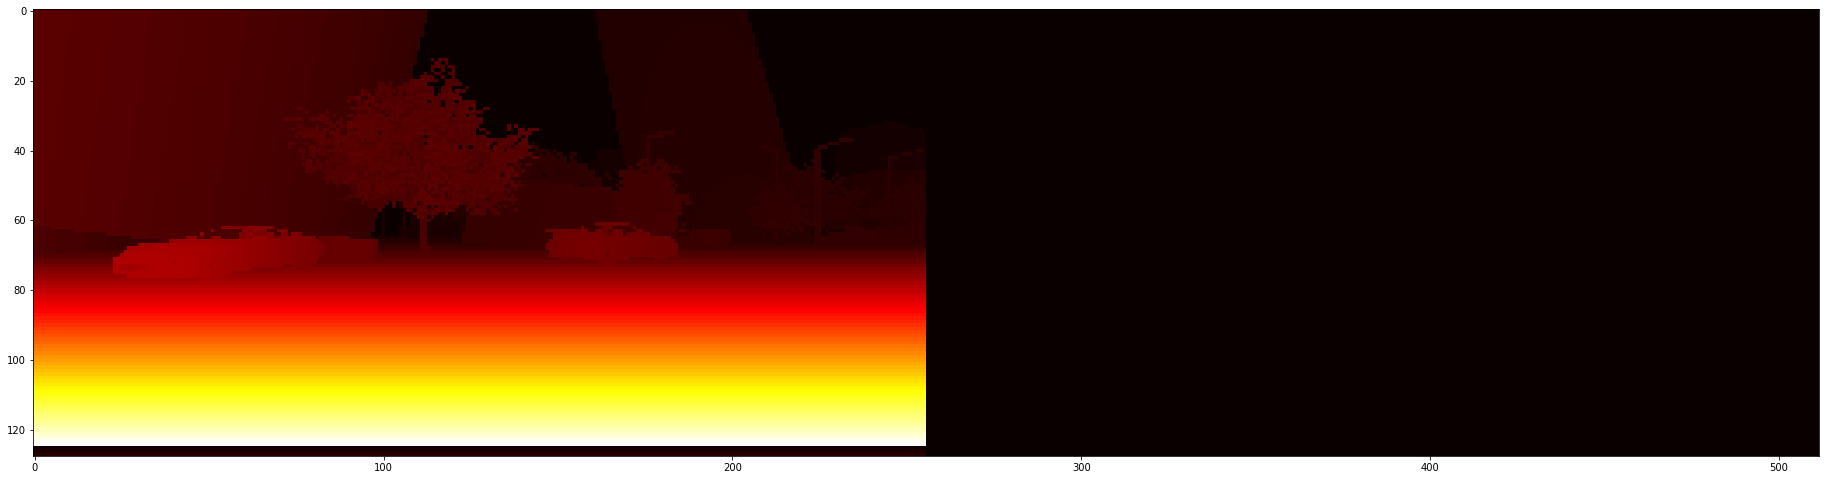

                         真实↑                                                               预测↑


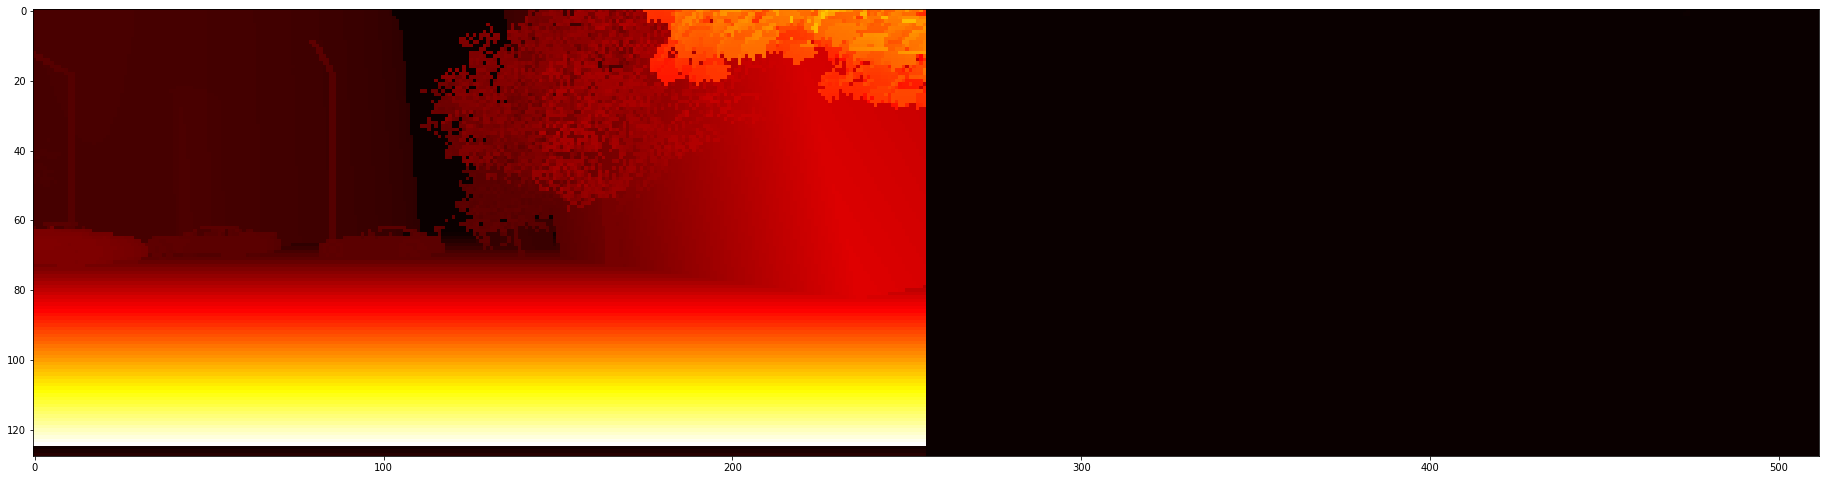

                         真实↑                                                               预测↑


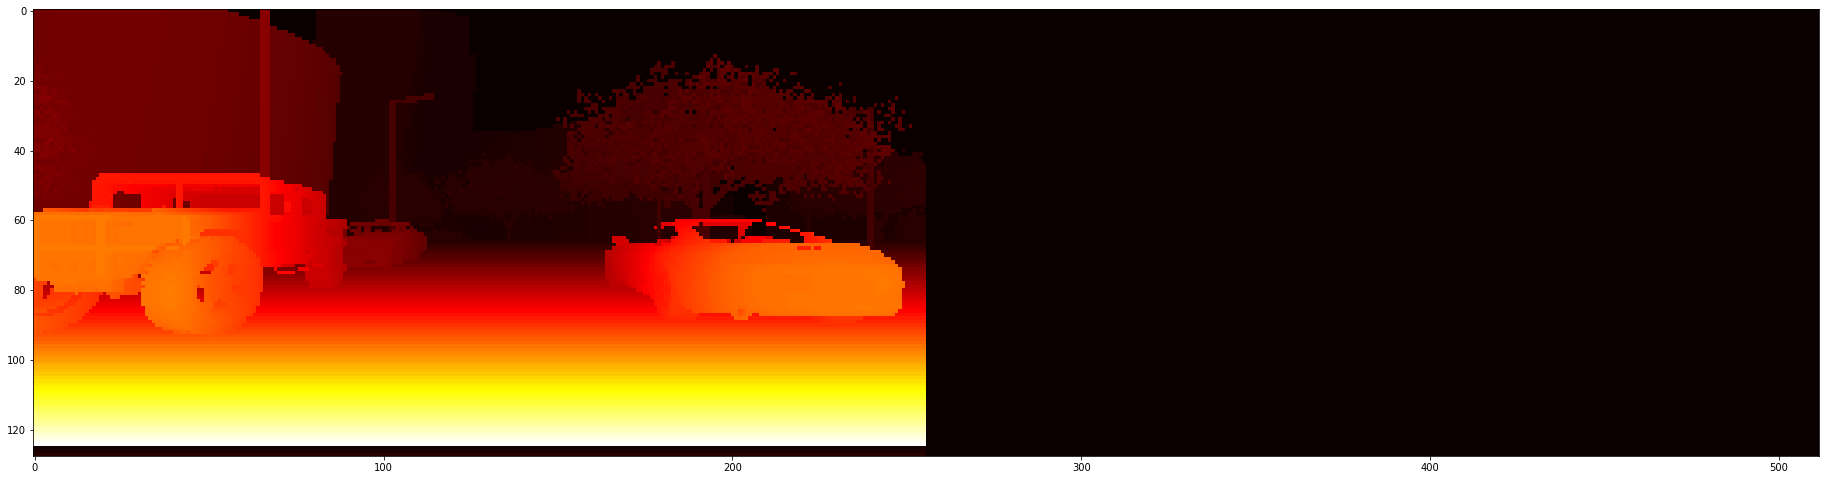

                         真实↑                                                               预测↑


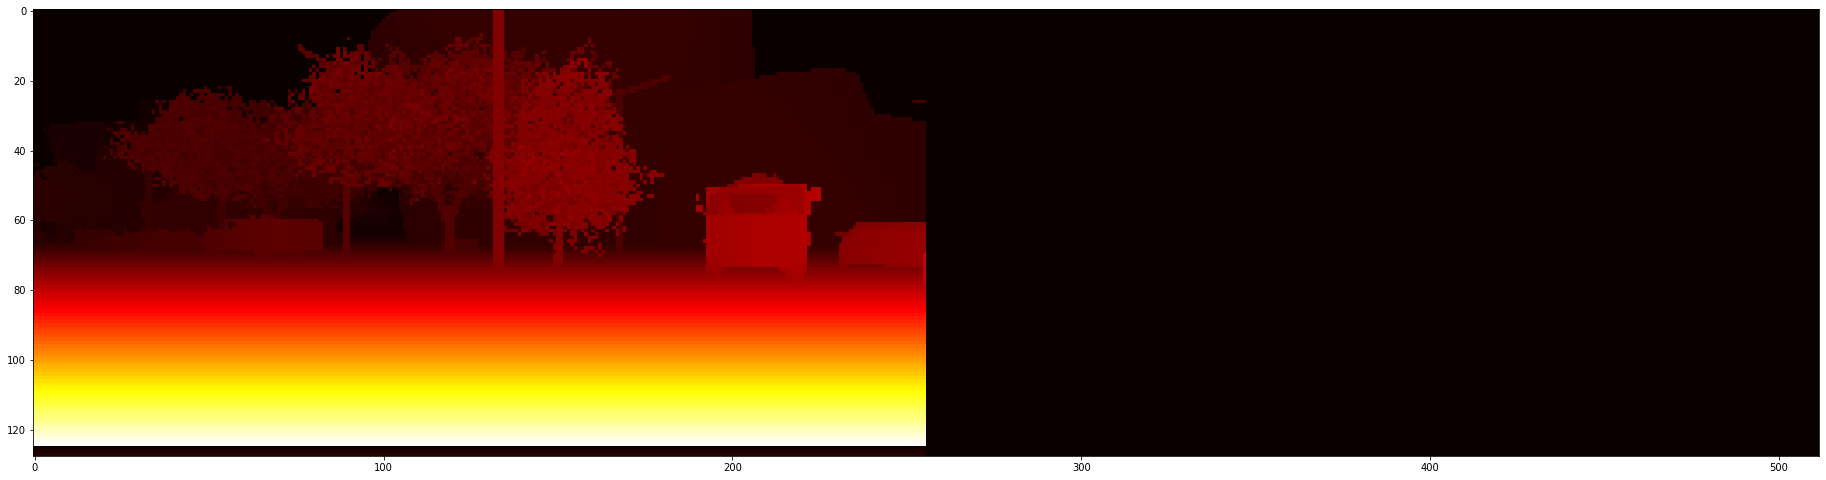

                         真实↑                                                               预测↑


In [5]:
# model.load_weights("./weight")
left_images,right_images,deep_images = next(trainset)
pred1,pred2,pred3,pred4,pred5 = model(left_images,right_images)
print(pred1.shape)
out = tf.squeeze(pred1)
for i in range(4):
    fig = plt.figure(figsize = (32,128))
    plt.imshow(tf.concat([deep_images[i],out[i]],axis = 1),cmap="hot")
    plt.show()
    print("                         真实↑                                                               预测↑")
